## Лабораторная №1 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from numpy.linalg import svd
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler

import time
from tqdm import tqdm  

## Считываем датасет

In [2]:
def filter_top_frequencies(df, column, freq_num):

    frequency = df[column].value_counts()
    top_values = frequency.nlargest(freq_num).index
    filtered_df = df[df[column].isin(top_values)].copy()

    replacement_dict = {value: i for i, value in enumerate(top_values)}
    filtered_df[column] = filtered_df[column].replace(replacement_dict)
    
    return filtered_df

In [3]:
def read_split_data(dataset = '', dataset2 = '', label = '', sep = ',', freq_num = 5):

    df = pd.read_csv(dataset, sep = sep)
    df2 = pd.read_csv(dataset2, sep = sep)


    concatenated_df = pd.concat([df, df2], axis=0, join='outer')

    df = filter_top_frequencies(concatenated_df, column = label, freq_num = freq_num)
    df = df.sample(frac=1,random_state=None).reset_index(drop=True)
    
    y = df.loc[:, label]
    df = df.drop(label, axis='columns')

    return df, y

In [5]:
outputs = 5
data, y = read_split_data(dataset = 'data/wine_quality-white.csv',  
                          dataset2 = 'data/wine_quality-red.csv', 
                          label = 'quality', 
                          sep = ';', 
                          freq_num = outputs)
print(data.shape)
print(y)

(6462, 11)
0       3
1       0
2       1
3       0
4       0
       ..
6457    1
6458    2
6459    0
6460    0
6461    0
Name: quality, Length: 6462, dtype: int64


## Обрабатываем данные, как кастомным PCA, так и встроенным

In [6]:
def custom_SVD(matrixA):
    if matrixA.shape[0] > matrixA.shape[1]:
        XTX = np.dot(matrixA.T, matrixA)  #  X^TX
        S, Vt = QR_algorithm(XTX)

        S = np.sqrt(S) 
        S_diag = np.diag(S)
        S_inv = np.linalg.inv(S_diag)

        U = np.dot(matrixA, np.dot(Vt, S_inv)) # U = X V S_inv
    else:
        XXT = np.dot(matrixA, matrixA.T)  # X^TX
        S, U = QR_algorithm(XXT)

        S = np.sqrt(S) 
        S_diag = np.diag(S)
        S_inv = np.linalg.inv(S_diag)
        #Vt = np.dot(np.dot(matrixA.T, U), S_inv)
        Vt = np.dot(S_inv, np.dot(U.T, matrixA)) # U = X V S_inv

        zero_matrix = np.zeros((matrixA.shape[1], matrixA.shape[1]))
        zero_matrix[:matrixA.shape[0], :] = Vt
        
        Vt = zero_matrix

    return U, S, Vt


def QR_decomposition(matrixA):
    matrixA_transposed = np.transpose(matrixA) # Транспонируем исходную матрицу для удобства
    n = len(np.array(matrixA)) #n - кол-во столбцов
    Q = [[0] * n for _ in range(n)] # Создаем нулевую матрицу Q
    R = [[0] * n for _ in range(n)] # Создаем нулевую матрицу R

    for i in range(n):
        v = matrixA_transposed[i].astype('float32') # Получаем вектор-столбец матрицы А, astype добавлен, т.к. возникала ошибка
        for j in range(i): # Ортоганализируем вектор v по отношению к предыдущим столбцам
            R[j][i] = np.dot(Q[j], v) # Скалярное произведение векторов
            #v -= np.multiply(R[j][i],Q[j])
            v = np.subtract(v, np.multiply(R[j][i],Q[j])) # Вычитаение проекции вектора v на вектор-столбец Q, чтобы v стал ортоганальным к Q
        # Нормализация вектора v
        R[i][i] = (sum(vi**2 for vi in v))**0.5
        Q[i] = np.divide(v, R[i][i])


    return np.transpose(Q), np.array(R)

def QR_algorithm(matrixA):
    n = matrixA.shape[0]
    eigenvalues = [[0] * n for _ in range(n)]
    eigenvectors = np.eye(n)

    for _ in range(100): #Используем 100 итераций разложения
        Q, R = QR_decomposition(matrixA)
        matrixA = np.dot(R, Q)
        eigenvectors = np.dot(eigenvectors, Q)

    # Собственные значения находятся на диагонали матрицы A
    eigenvalues = np.diag(matrixA)

    return eigenvalues, eigenvectors


In [7]:
def PCA_custom(df, variance_pecr = 0.9):
    data = df

    # Центрирование по медиане и маштабирование до [-1,1]
    data_centered = data - np.median(data, axis=0)
    data_centered /= np.max(np.abs(data_centered),axis=0)

    # SVD
    #U, S, Vt = svd(data_centered)
    U, S, Vt = custom_SVD(data_centered)
    n_comp = pick_components(S, variance_pecr)

    Ur = U[:,:n_comp]
    Sr = np.diag(S[:n_comp])
    data_new = np.dot(Ur, Sr)

    return data_new

def pick_components(array, variance_pecr):

    variance = array**2
    target_variance = np.sum(variance) * variance_pecr

    var_sum = 0
    num_elements = 0

    for i in variance:
        var_sum += i
        num_elements += 1
        if var_sum >= target_variance:
            break

    return num_elements

def PCA_SVD(dd,pca = 3):
    if isinstance(dd, np.ndarray):
        data_centered=dd
    else:
        dd = dd.to_numpy()
        # Центрирование по медиане и маштабирование до [-1,1]
        data_centered = dd - np.median(dd, axis=0)
        data_centered /= np.max(np.abs(data_centered),axis=0)

    dd=data_centered.T

    # SVD
    #U, S, Vt = svd(dd)
    U, S, Vt = custom_SVD(dd)

    print('VAR_2%:', (S[0]+S[1])/sum(S))
    print('VAR_3%:', (S[0]+S[1]+S[2])/sum(S))

    S=np.diag(S)

    So = S
    Sn = np.zeros((dd.shape[0], dd.shape[1]))
    Sn[:So.shape[0], :So.shape[1]] = So
    S=Sn

    S[:, pca:] = 0
    U[:, pca:] = 0
    Vt[pca:, :] = 0

    RR=U@S@Vt
    print(RR.shape)
    print(pd.DataFrame(RR).T.head())
    RR_r = []
    for i in range(RR.shape[0]):
        RR2 = RR[RR_r + [i], :]
        if np.linalg.matrix_rank(RR2) == len(RR_r) + 1:
            RR_r.append(i)

    RR_r = RR[RR_r]

    RR_itog=RR_r.T
    RR_itog

    return RR_itog

### Kernal PCA

In [8]:
A=data.to_numpy()

def polinomF(x,y):
    return ((np.dot(x, y)+1)**1)

def RadialBasisF(x,y, sigma=0.1):
    return np.exp(-np.linalg.norm(x - y) ** 2 / (2 * (sigma ** 2)))

def SigmoidalF(x, y):
    return np.tanh(0.01*np.dot(x, y)+0.1)


def K_centerd(K):
    N = K.shape[0]
    one_n = np.ones((N, N)) / N
    K_centered = K - one_n @ K - K @ one_n + one_n @ K @ one_n
    return K_centered

def K_matrix(A, kernel_function):
    zero_matrix = np.zeros((A.shape[0], A.shape[0]))
    
    start_time = time.time() 
    
    for i in tqdm(range(A.shape[0]), desc="Создание Kernel Matrix", unit="строк"):
        for g in range(A.shape[0]):
            zero_matrix[i, g] = kernel_function(A[i], A[g])
    
    K_centered = K_centerd(zero_matrix)
    
    end_time = time.time() 
    print(f"Общее время: {end_time - start_time:.2f} секунд")
    return K_centered

K = K_matrix(A, polinomF)
K # примерно 50 секунд

Создание Kernel Matrix: 100%|██████████| 6462/6462 [00:32<00:00, 198.40строк/s]


Общее время: 39.85 секунд


array([[ 3419.15537758, -1834.44583299, -3305.11277111, ...,
         5570.31825577,  6160.75598922, -2495.7689492 ],
       [-1834.44583299,  1018.96845443,  1798.16057075, ...,
        -2996.46155279, -3318.37816396,  1249.75530658],
       [-3305.11277111,  1798.16057075,  3623.20901353, ...,
        -5584.48331539, -6180.89884315,  2294.41941393],
       ...,
       [ 5570.31825577, -2996.46155279, -5584.48331539, ...,
         9178.52034009, 10146.41470486, -4014.04603887],
       [ 6160.75598922, -3318.37816396, -6180.89884315, ...,
        10146.41470486, 11221.61630409, -4433.08243663],
       [-2495.7689492 ,  1249.75530658,  2294.41941393, ...,
        -4014.04603887, -4433.08243663,  2079.13162428]])

In [9]:
'''
Наш алгоритм работает, однако занчительно медленне, чем встроенный
Для демонстрации можно использовать матрицу K, расположенную ниже


K = np.array([[1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
               [2, 11, 12, 13, 14, 15, 16, 17, 18, 19],
               [3, 12, 20, 21, 22, 23, 24, 25, 26, 27],
               [4, 13, 21, 28, 29, 30, 31, 32, 33, 34],
               [5, 14, 22, 29, 35, 36, 37, 38, 39, 40],
               [6, 15, 23, 30, 36, 41, 42, 43, 44, 45],
               [7, 16, 24, 31, 37, 42, 46, 47, 48, 49],
               [8, 17, 25, 32, 38, 43, 47, 50, 51, 52],
               [9, 18, 26, 33, 39, 44, 48, 51, 53, 54],
               [10, 19, 27, 34, 40, 45, 49, 52, 54, 55]])

'''
def sobstvenvectors(VV):
    if VV==1:
        start_time = time.time()
        U, S, Vt = custom_SVD(K)
        end_time = time.time()
        SUM=0
        KolvoVectorov=0
        print(f"Общее время: {end_time - start_time:.2f} секунд")
        for i in range(len(S)):
            KovolVectorov=i
            SUM+=S[i]
            if SUM/sum(S)>=0.85:
                KovolVectorov+=1
                break
            
        Vt=Vt[:KovolVectorov]

        NN = np.linalg.norm(Vt)
        
        normalized_vector1 = Vt / NN
        normalized_vector2 = normalized_vector1/ (S[KovolVectorov-1]**0.5)
        normalized_vector2
        
        print(sum(sum(normalized_vector2 * normalized_vector2)) * S[KovolVectorov - 1], 'почти 1)))') #условие равенства 

        X_transformed = np.dot(K, normalized_vector2.T)

        return X_transformed 
        
    else:
        eigenvalues, eigenvectors = np.linalg.eigh(K)
        sorted_indices = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[sorted_indices]
        eigenvectors = eigenvectors[:, sorted_indices]
        
        total_variance = np.sum(eigenvalues)
        top_n_variance = np.sum(eigenvalues[:1])
        explained_variance_top = top_n_variance / total_variance
        #print(explained_variance_top)

        FIRSTglavnCOMP=eigenvectors[:1]
        #print(FIRSTglavnCOMP)
        FIRSTznach=eigenvalues[:1]
        NN = np.linalg.norm(FIRSTglavnCOMP)
        
        normalized_vector1 = FIRSTglavnCOMP / NN
        normalized_vector2 = normalized_vector1/ (FIRSTznach**0.5)
        normalized_vector2
        
        print((sum(sum(normalized_vector2* normalized_vector2))*FIRSTznach)[0],'почти 1)))') #условие равенства 

        X_transformed = np.dot(K, normalized_vector2.T)
        return X_transformed

X_transformed=sobstvenvectors(2) #1/2 (собственный/встроенный алгоритм)
X_transformed

0.9999999999999999 почти 1)))


array([[-0.10698024],
       [ 0.06926726],
       [ 0.11569497],
       ...,
       [-0.17898467],
       [-0.19918623],
       [ 0.0431836 ]])

### Встроенный Kernal PCA

In [10]:
B=data.to_numpy()
scaler = StandardScaler()
BB = scaler.fit_transform(B)


kpca_poly = KernelPCA(n_components=1, kernel='poly', degree=2)
BB = kpca_poly.fit_transform(BB)

### Получившиеся наборы данных

In [11]:
# Центрирование по медиане и маштабирование до [-1,1]
data_centered = data - np.median(data, axis=0)
data_centered /= np.max(np.abs(data_centered),axis=0)


new_data = PCA_custom(data, variance_pecr = 0.95)
new_data = pd.DataFrame(new_data)
print("---Кастомный PCA---")
print(new_data.shape)
print(new_data)
print("---------")

pca = PCA(n_components = 3)
pca.fit(data_centered)
data_pca = pca.transform(data_centered)
data_pca = pd.DataFrame(data_pca)
print("---Встроенный PCA---")
print(data_pca.shape)
print(data_pca.head())
print("---------")

pcawithsvd=PCA_SVD(data,pca = 8)
pcawithsvd = pd.DataFrame(pcawithsvd)
print("---PCA_SVD---")
print(pcawithsvd.shape)
print(pcawithsvd.head())
print("---------")


KERNAL_PCA_SVD = pd.DataFrame(X_transformed)
print("---KERNAL_PCA_SVD---")
print(KERNAL_PCA_SVD.shape)
print(KERNAL_PCA_SVD.head())
print("---------")

KERNAL_PCA_vst = pd.DataFrame(BB)
print("---KERNAL_PCA_SVD---")
print(KERNAL_PCA_vst.shape)
print(KERNAL_PCA_vst.head())
print("---------")

---Кастомный PCA---
(6462, 8)
             0         1         2         3         4         5         6  \
0     0.159730 -0.335928  0.152864  0.031489 -0.247007  0.004082  0.152361   
1     0.252517  0.615828  0.004401  0.217736 -0.009728 -0.052520 -0.043134   
2    -0.404610 -0.125523 -0.053639  0.036062 -0.084239 -0.018707 -0.028729   
3    -0.111542 -0.164817 -0.179606  0.124760  0.160248 -0.105251  0.125186   
4     0.475397 -0.341268  0.413673  0.312685  0.196915 -0.053537  0.036067   
...        ...       ...       ...       ...       ...       ...       ...   
6457 -0.099614  0.111490 -0.045581 -0.034588 -0.023246 -0.080339  0.015402   
6458  0.453127  0.652993 -0.191386  0.180975  0.035369 -0.138627 -0.174415   
6459  0.507317 -0.267413  0.360645  0.214302  0.318383 -0.043373  0.109432   
6460  0.377002 -0.309858  0.447500 -0.036502  0.170691  0.049509 -0.057435   
6461 -0.346522 -0.022205  0.073605  0.034614  0.051953  0.154790  0.122893   

             7  
0     0.032200  

### Визуализация 2D

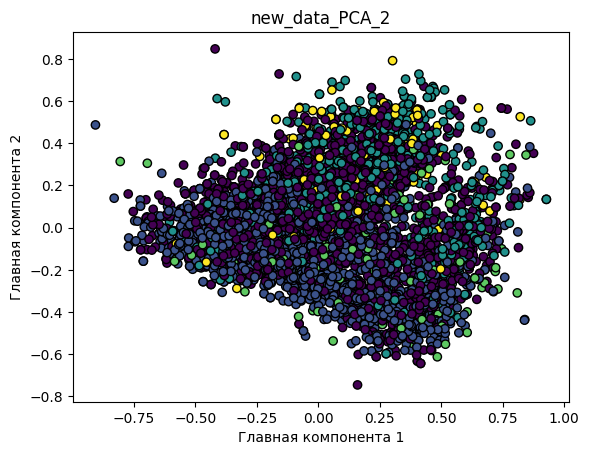

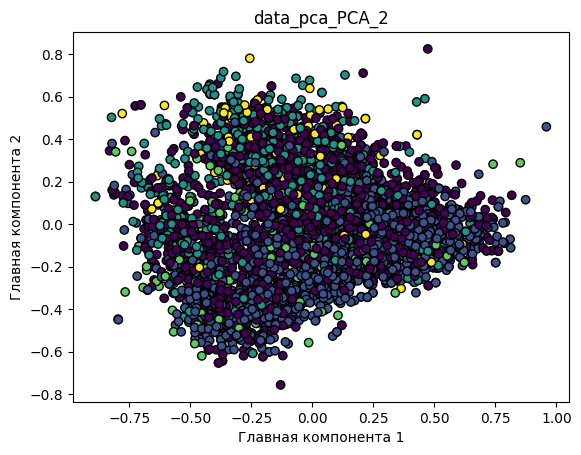

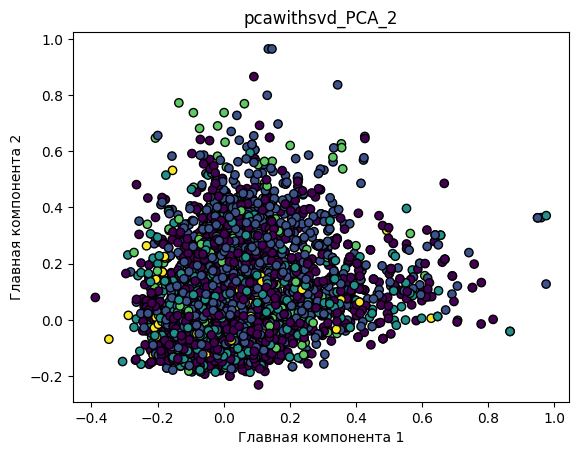

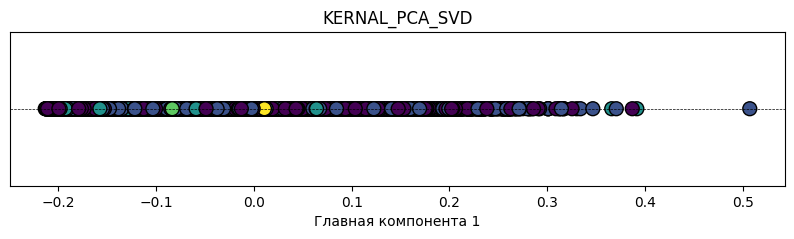

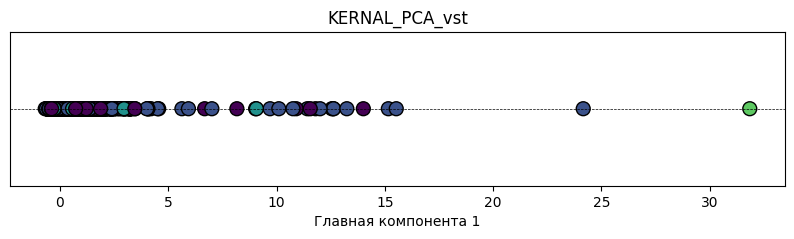

In [12]:
plt.scatter(new_data.values[:, 0], new_data.values[:, 1], c=y, cmap='viridis', edgecolor='k')
plt.title('new_data_PCA_2')
plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')
plt.show()

plt.scatter(data_pca.values[:, 0], data_pca.values[:, 1], c=y, cmap='viridis', edgecolor='k')
plt.title('data_pca_PCA_2')
plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')
plt.show()

plt.scatter(pcawithsvd.values[:, 0], pcawithsvd.values[:, 1], c=y, cmap='viridis', edgecolor='k')
plt.title('pcawithsvd_PCA_2')
plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')
plt.show()


data_flat = KERNAL_PCA_SVD[0].to_numpy().flatten()  
plt.figure(figsize=(10, 2))  
plt.scatter(data_flat, np.zeros_like(data_flat), c=y, cmap='viridis', edgecolor='k', s=100)  
plt.title('KERNAL_PCA_SVD')
plt.xlabel('Главная компонента 1')  
plt.yticks([])     
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')  
plt.grid(False)     
plt.show()


data_flat = KERNAL_PCA_vst[0].to_numpy().flatten()  
plt.figure(figsize=(10, 2))  
plt.scatter(data_flat, np.zeros_like(data_flat), c=y, cmap='viridis', edgecolor='k', s=100)  
plt.title('KERNAL_PCA_vst')
plt.xlabel('Главная компонента 1')  
plt.yticks([])     
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')  
plt.grid(False)     
plt.show()

### Визуализация 3D

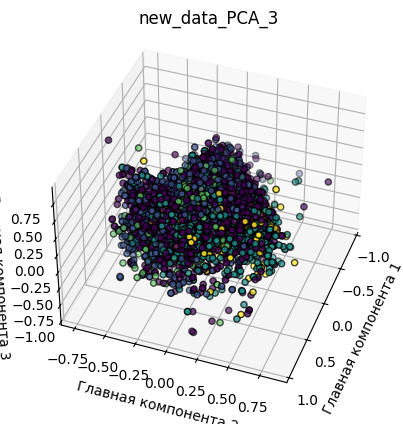

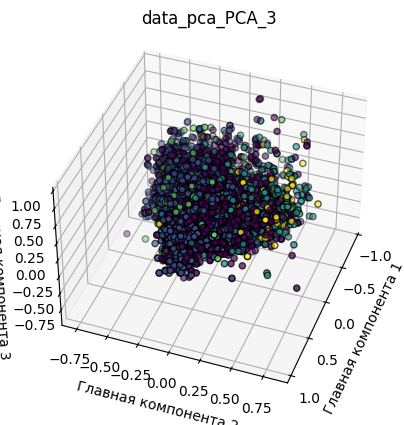

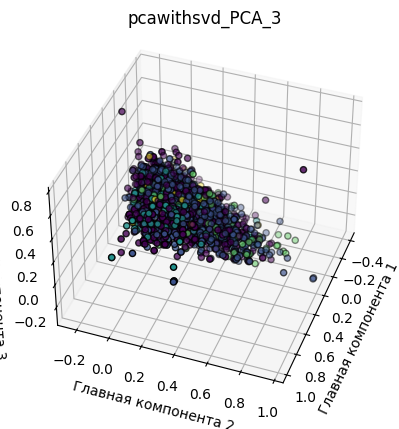

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(new_data.values[:, 0], new_data.values[:, 1], new_data.values[:, 2], c=y, cmap='viridis', edgecolor='k')
ax.set_title('new_data_PCA_3')
ax.set_xlabel('Главная компонента 1')
ax.set_ylabel('Главная компонента 2')
ax.set_zlabel('Главная компонента 3')
ax.view_init(elev=40, azim=20)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data_pca.values[:, 0], data_pca.values[:, 1], data_pca.values[:, 2], c=y, cmap='viridis', edgecolor='k')
ax.set_title('data_pca_PCA_3')
ax.set_xlabel('Главная компонента 1')
ax.set_ylabel('Главная компонента 2')
ax.set_zlabel('Главная компонента 3')
ax.view_init(elev=40, azim=20)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pcawithsvd.values[:, 0], pcawithsvd.values[:, 1], pcawithsvd.values[:, 2], c=y, cmap='viridis', edgecolor='k')
ax.set_title('pcawithsvd_PCA_3')
ax.set_xlabel('Главная компонента 1')
ax.set_ylabel('Главная компонента 2')
ax.set_zlabel('Главная компонента 3') 
ax.view_init(elev=40, azim=20)
plt.show()



## Сплитаем данные
train_data - полученные кастомным способом

train_data2 - полученные встроенным способом

In [14]:
def split_data(data, y, train_size = 0.9):
    # Calc train size
    train_len = int(len(data) * train_size)

    # Separate test and train labels
    y_train = y[:train_len]
    y_test = y[train_len:]

    # Split test and train
    train_data = data[:train_len]
    test_data = data[train_len:]
    
    return train_data, y_train, test_data, y_test

In [15]:
train_data, y_train, test_data, y_test = split_data(data, y)
train_data2, y_train2, test_data2, y_test2 = split_data(new_data, y)
train_data3, y_train3, test_data3, y_test3 = split_data(data_pca, y)
train_data4, y_train4, test_data4, y_test4 = split_data(pcawithsvd, y)
train_data5, y_train5, test_data5, y_test5 = split_data(KERNAL_PCA_SVD, y)
train_data6, y_train6, test_data6, y_test6 = split_data(KERNAL_PCA_vst, y)

## Описываем модель

In [16]:
class PercNeuralNetwork(nn.Module):
    
    def __init__(self, inputs, n_inside, outputs, prob):
        super(PercNeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(inputs, n_inside)
        self.fc2 = nn.Linear(n_inside, outputs)
        self.fc1_act = nn.ReLU()
        self.dropout = nn.Dropout(p=prob)
        
    def forward(self,x):
        y = self.fc1(self.dropout(x))
        y = self.fc1_act(y)
        y = self.fc2(y)
        return y

In [17]:
n_inside = 50 # Внутр размер сети
outputs = 5 # Размер выходов сети
num_epochs=125 # Количество эпох которое будет обучаться модель
batch_size=32 # Размер батча, каоторый будет одновременно подаваться в модель
learning_rate=0.0003 # Скорость обучения

In [18]:

def train_model(model, train_data, y_train, test_data, y_test, num_epochs=10, batch_size=64, learning_rate=0.001, log=True):
    # Переводим модель на нужное устройство
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    # Перевод данных в тензоры
    train_data_tensor = torch.tensor(train_data.values, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.long).to(device)
    test_data_tensor = torch.tensor(test_data.values, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.long).to(device)
    
    # Определяем функцию потерь и оптимизатор
    loss_func = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Количество примеров
    train_len = len(train_data_tensor)

    # Списки для хранения значений потерь и точности
    train_losses = []
    test_losses = []
    test_accuracies = []
    f1_scores = []  # Добавляем список для F1-меры
    
    # Цикл по эпохам
    for epoch in range(num_epochs):
        # Перемешиваем данные в начале каждой эпохи
        permutation = torch.randperm(train_len).to(device)

        model.train()  # Переводим модель в режим обучения
        total_loss = 0  # Для хранения суммарных потерь
        
        # Обучение в батчах
        for i in range(0, train_len, batch_size):
            # Получаем текущий батч
            indices = permutation[i:i+batch_size]
            batch_data = train_data_tensor[indices]
            batch_labels = y_train_tensor[indices]
            
            # Обнуляем градиенты
            optimizer.zero_grad()
            
            # Прямой проход
            output = model(batch_data)
            
            # Вычисляем потери
            loss = loss_func(output, batch_labels)
            
            # Обратный проход
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        # Оценка точности и F1-меры на тестовых данных после каждой эпохи
        model.eval()
        with torch.no_grad():
            # Считаем результаты на test данных
            test_output = model(test_data_tensor)

            # Выбираем какой ответ дала модель
            probabilities = torch.softmax(test_output, dim=1)
            predictions = torch.argmax(probabilities, dim=1)

            test_loss = loss_func(test_output, y_test_tensor).item()

            test_accuracy = accuracy(predictions, y_test_tensor)

            f1 = f1_score(predictions.cpu().numpy(), y_test_tensor.cpu().numpy())

        # Сохраняем потери, точность и F1-меру
        train_losses.append(total_loss / (train_len / batch_size))
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        f1_scores.append(f1)
        
        if log:
            print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {train_losses[-1]:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, F1 Score: {f1:.4f}')

    # Визуализация
    plt.figure(figsize=(12, 6))

    # График потерь
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # График точности
    plt.subplot(1, 3, 2)
    plt.plot(test_accuracies, label='Test Accuracy', color='orange')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # График F1-меры
    plt.subplot(1, 3, 3)
    plt.plot(f1_scores, label='F1 Score', color='green')
    plt.title('F1 Score over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()

    plt.show()

# Функция для вычисления точности
def accuracy(output, labels):
    # Вычисляем количество правильных предсказаний
    correct = (output == labels).sum().item()

    return correct / len(labels) * 100

def f1_score(y_pred, y_true):
    unique_classes = np.unique(np.concatenate([y_true, y_pred]))

    f1_scores = []
    weights = []
    
    for cls in unique_classes:
        tp = np.sum((y_true == cls) & (y_pred == cls))
        fp = np.sum((y_true != cls) & (y_pred == cls))
        fn = np.sum((y_true == cls) & (y_pred != cls))
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        
        if precision + recall > 0:
            f1 = 2 * (precision * recall) / (precision + recall)
        else:
            f1 = 0
        
        support = np.sum(y_true == cls)
        f1_scores.append(f1)
        weights.append(support)
    
    weighted_f1 = np.average(f1_scores, weights=weights)
    return weighted_f1

# Результаты

### Необработанные данные

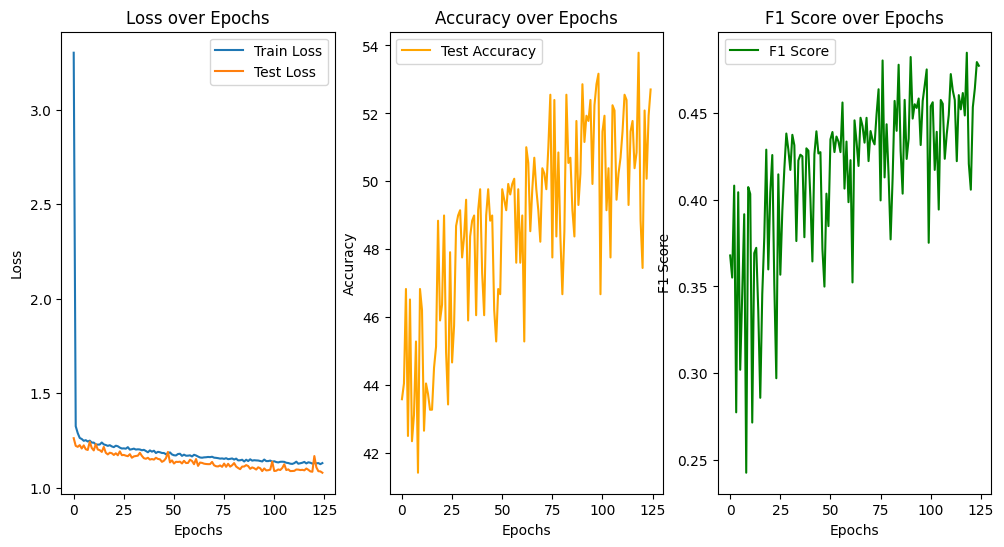

Общее время: 5.60 секунд


In [19]:
model = PercNeuralNetwork(inputs = train_data.shape[1], n_inside = n_inside, outputs = outputs, prob = 0.1)
# Обучаем модель на данных
start_time = time.time()
train_model(model, train_data, y_train, test_data, y_test, num_epochs=num_epochs, batch_size=batch_size, learning_rate=learning_rate, log=False)
end_time = time.time()
print(f"Общее время: {end_time - start_time:.2f} секунд")

### Кастомный PCA

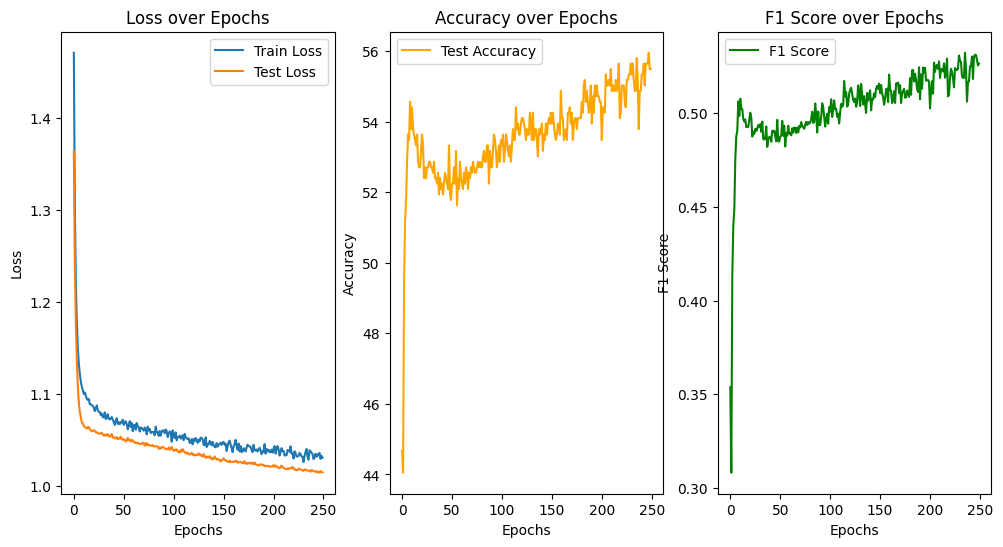

Общее время: 9.87 секунд


In [20]:
model = PercNeuralNetwork(inputs = train_data2.shape[1], n_inside = n_inside, outputs = outputs, prob = 0.1)
# Обучаем модель на данных
start_time = time.time()
train_model(model, train_data2, y_train2, test_data2, y_test2, num_epochs=num_epochs*2, batch_size=batch_size, learning_rate=learning_rate, log=False)
end_time = time.time()
print(f"Общее время: {end_time - start_time:.2f} секунд")

### Встроенный PCA

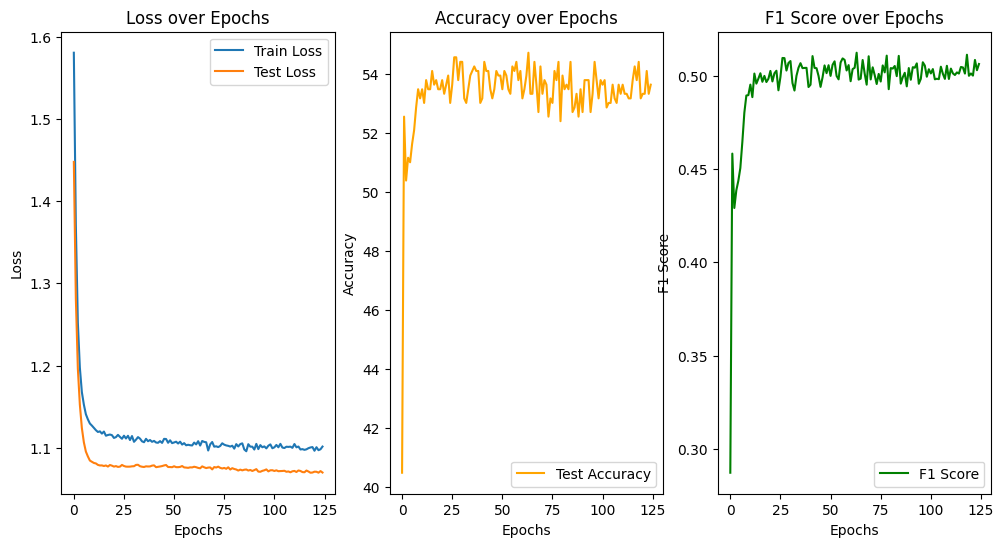

Общее время: 4.80 секунд


In [21]:
model = PercNeuralNetwork(inputs = train_data3.shape[1], n_inside = n_inside, outputs = outputs, prob = 0.1)
# Обучаем модель на данных
start_time = time.time()
train_model(model, train_data3, y_train3, test_data3, y_test3, num_epochs=num_epochs, batch_size=batch_size, learning_rate=learning_rate, log=False)
end_time = time.time()
print(f"Общее время: {end_time - start_time:.2f} секунд")

### PCA FROM SVD

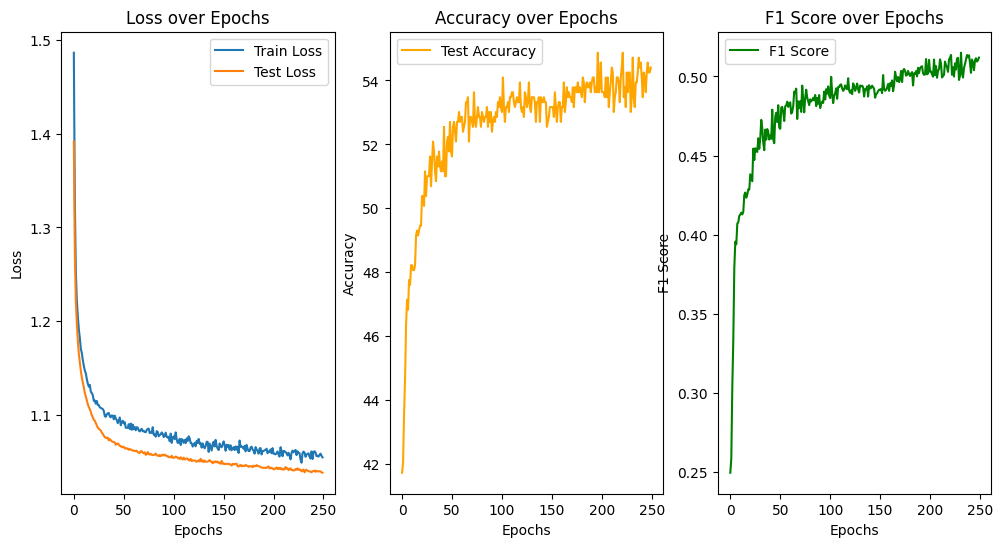

Общее время: 9.33 секунд


In [22]:
model = PercNeuralNetwork(inputs = train_data4.shape[1], n_inside = n_inside, outputs = outputs, prob = 0.1)
# Обучаем модель на данных
start_time = time.time()
train_model(model, train_data4, y_train4, test_data4, y_test4, num_epochs=num_epochs*2, batch_size=batch_size, learning_rate=learning_rate, log=False)
end_time = time.time()
print(f"Общее время: {end_time - start_time:.2f} секунд")

### KERNAL PCA

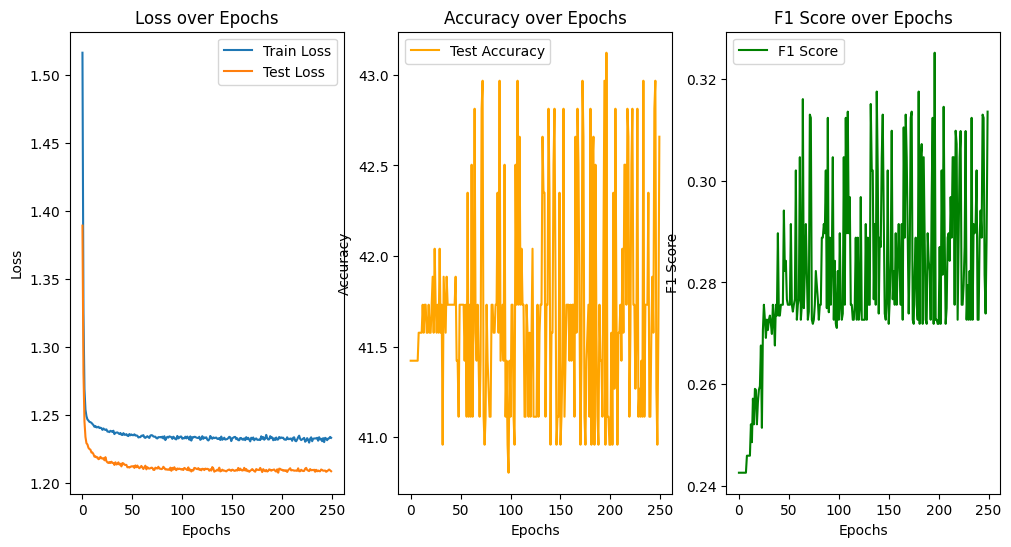

Общее время: 9.13 секунд


In [23]:
model = PercNeuralNetwork(inputs = train_data5.shape[1], n_inside = n_inside, outputs = outputs, prob = 0.1)
# Обучаем модель на данных
start_time = time.time()
train_model(model, train_data5, y_train5, test_data5, y_test5, num_epochs=num_epochs*2, batch_size=batch_size, learning_rate=learning_rate, log=False)
end_time = time.time()
print(f"Общее время: {end_time - start_time:.2f} секунд")

### Встроенный KERNAL PCA

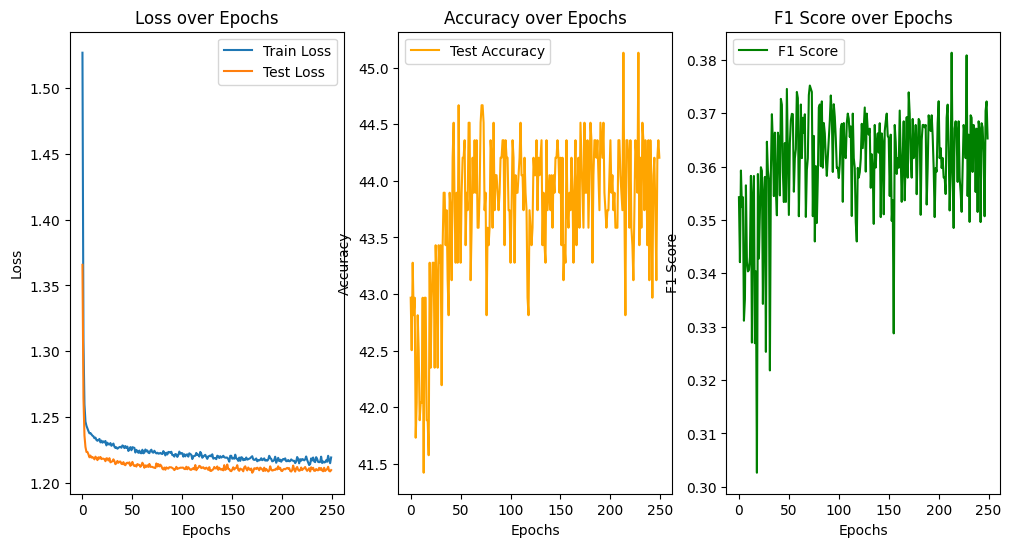

Общее время: 9.22 секунд


In [24]:
model = PercNeuralNetwork(inputs = train_data6.shape[1], n_inside = n_inside, outputs = outputs, prob = 0.1)
# Обучаем модель на данных
start_time = time.time()
train_model(model, train_data6, y_train6, test_data6, y_test6, num_epochs=num_epochs*2, batch_size=batch_size, learning_rate=learning_rate, log=False)
end_time = time.time()
print(f"Общее время: {end_time - start_time:.2f} секунд")
